In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()

In [5]:
class Measurements(Base):
    __tablename__ = "measurements"
    id = Column(Integer, primary_key=True)
    station = Column(String)
    date = Column(String)
    prcp = Column(Float)
    tobs = Column(Float)

In [6]:
class Station(Base):
    __tablename__ = "station"
    id = Column(Integer, primary_key=True)
    station = Column(String)
    name = Column(String)
    latitude = Column(Float)
    longitude = Column(Float)
    elevation = Column(Float)

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session.query(Measurement.prcp).order_by(Measurement.date.desc()).all()

[(0.0),
 (0.0),
 (0.08),
 (0.45),
 (0.0),
 (0.0),
 (0.5),
 (0.0),
 (0.02),
 (None),
 (0.56),
 (0.0),
 (0.01),
 (None),
 (0.0),
 (0.0),
 (None),
 (0.09),
 (0.0),
 (0.0),
 (0.06),
 (None),
 (0.0),
 (0.05),
 (0.01),
 (0.13),
 (0.0),
 (0.07),
 (0.12),
 (0.42),
 (0.02),
 (0.0),
 (0.06),
 (0.32),
 (0.42),
 (0.0),
 (0.01),
 (0.08),
 (0.0),
 (0.22),
 (0.0),
 (None),
 (0.0),
 (0.0),
 (None),
 (0.0),
 (0.0),
 (0.14),
 (0.0),
 (0.0),
 (0.0),
 (None),
 (0.0),
 (0.0),
 (0.0),
 (0.07),
 (0.0),
 (0.0),
 (0.15),
 (0.0),
 (0.1),
 (0.0),
 (0.34),
 (0.0),
 (0.0),
 (0.0),
 (0.05),
 (0.0),
 (0.0),
 (0.0),
 (0.0),
 (None),
 (0.0),
 (0.06),
 (None),
 (0.02),
 (0.04),
 (0.0),
 (0.0),
 (0.0),
 (0.01),
 (0.0),
 (0.06),
 (0.0),
 (0.05),
 (0.0),
 (0.25),
 (0.02),
 (0.12),
 (0.0),
 (None),
 (0.0),
 (0.0),
 (None),
 (None),
 (0.0),
 (0.0),
 (0.0),
 (0.0),
 (0.0),
 (0.0),
 (0.0),
 (0.3),
 (0.0),
 (0.06),
 (0.02),
 (0.0),
 (0.23),
 (0.3),
 (0.0),
 (0.13),
 (0.14),
 (0.01),
 (0.0),
 (0.09),
 (0.4),
 (0.0),
 (0.0),
 (0

In [13]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = session.query (Measurement.date).order_by(Measurement.date.desc()).first()
year_ago = year_ago[0]

year_ago = dt.datetime.strptime(year_ago, "%Y-%m-%d") - dt.timedelta(days=366)
print(year_ago)

2016-08-22 00:00:00


In [14]:
# Perform a query to retrieve the data and precipitation scores
measurements = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
date = []
prcp = []

prcp_df = pd.DataFrame(measurements)
prcp_df.reset_index(date)
prcp_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [16]:
# Sort the dataframe by date
prcp_df['date'] = pd.to_datetime(prcp_df['date'], format='%Y-%m-%d')
# Set index to date
prcp_df.set_index('date', inplace=True)
prcp_df = prcp_df.sort_values(by='date', ascending=True).dropna()

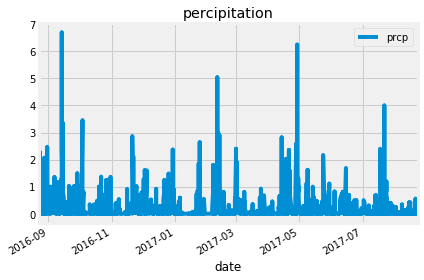

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title='percipitation')
plt.tight_layout()
plt.savefig('Percipitation.png')
plt.show()

![precipitation](Images/precipitation.png)

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [19]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active = session.query(Station.station, func.count(Measurement.id)).select_from(Measurement).\
   join(Station, Measurement.station == Station.station).group_by(Station.station).\
   order_by(func.count(Measurement.id).desc()).all()
for result in active:
   print(f"Station: {result[0]}\tCount: {result[1]}")

Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [21]:
active[0][0]

'USC00519281'

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

lowest = session.query(func.min(Measurement.tobs)).all()
highest = session.query(func.max(Measurement.tobs)).all()
average = session.query(func.avg(Measurement.tobs)).all()
print(lowest, highest, average)

[(53.0,)] [(87.0,)] [(73.09795396419437,)]


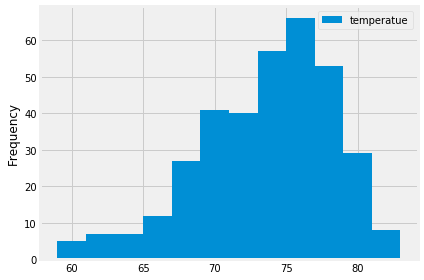

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_years_temps = session.query(Measurement.tobs).filter(Measurement.date >= year_ago).\
   filter(Measurement.station == active[0][0]).all()

last_years_temps_df = pd.DataFrame(last_years_temps, columns=['temperatue'])

fig, ax = plt.subplots()
last_years_temps_df.plot.hist(bins = 12, ax = ax)
plt.savefig("Temperatures.png")
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
